# Energy Relaxation Measurement

> 2019-04-12

This document implements the energy relaxation measurement shown in the IBM Q Experience User Guide. It also features some original analysis, which is probably wrong.

In [1]:
# import standard libraries
import qiskit as q
import qiskit.tools.monitor as monitor
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Our circuit will consist of a preparation stage and a measurement stage, with varying numbers of idle (identity) gates placed between them. Theoretically, when the idle time becomes too great, the excited $\vert 1 \rangle$ states should decay to $\vert 0 \rangle$ states.

In [2]:
qr = q.QuantumRegister(1, 'q')
cr = q.ClassicalRegister(1, 'c')

# preparation stage
prepare = q.QuantumCircuit(qr, cr)
prepare.x(qr[0])
prepare.barrier()

# measurement stage
measure = q.QuantumCircuit(qr, cr)
measure.measure(qr, cr)

# build idle stages
circuits = []
for n in range(50):
    idle = q.QuantumCircuit(qr, cr)
    for _ in range(45 * n):
        idle.iden(qr[0])
    circuits += [prepare + idle + measure]

As an example, this is what the first circuit (zero delay) looks like:

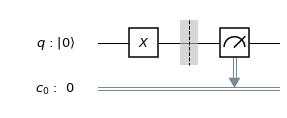

In [3]:
circuits[0].draw(output='mpl')

For each circuit, we are interested in the frequency of measuring the $\vert 1 \rangle$ state. We want to plot this frequency $p(1)$ against the idle delay $t$ in the circuit. We will extract the numbers we want from each experimental run with the fucntion:

In [4]:
from collections import Counter

# analyze a trial and return the results
def count_results(result, circuits, shots=1024):
    freq = []    # frequency of '1' state
    stderr = []  # standard error

    for c in circuits:
        trial = Counter(result.get_counts(c))
        p = trial['1'] / shots
        freq += [p]
        stderr += [np.sqrt(p * (1 - p) / shots)]
    return freq, stderr

Using the simulator, we see that in the ideal case, we should measure a $\vert 1 \rangle$ each time. (i.e. $p(1)=1$ for all values of $t$)

Text(0, 0.5, 'p(1)')

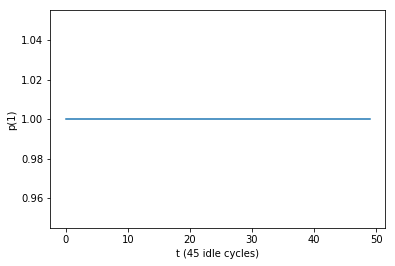

In [5]:
# run on simulator
simulator = q.BasicAer.get_backend('qasm_simulator')
sim_job = q.execute(circuits, simulator, shots=1024)
sim_p, sim_s = count_results(sim_job.result(), circuits)

# plot simulation results
sim_fig, sim_ax = plt.subplots()
sim_ax.errorbar(range(len(circuits)), sim_p, sim_s)
sim_ax.set_xlabel('t (45 idle cycles)')
sim_ax.set_ylabel('p(1)')

Does this hold on the physical device? We can execute this on the IBM backend and find out.

HTML(value="<p style='font-size:16px;'>Job Status: job has successfully run </p>")

Text(0, 0.5, 'p(1)')

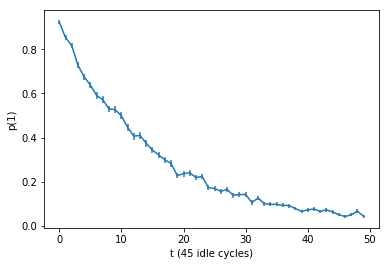

In [6]:
# locate least busy IBM device backend
q.IBMQ.load_accounts()
backends = q.IBMQ.backends(filters=lambda x:
                           not x.configuration().simulator)
best = q.providers.ibmq.least_busy(backends)

# run the trials on that backend
exp_job = q.execute(circuits, backend=best, shots=1024,
                    max_credits=10)
monitor.job_monitor(exp_job)
exp_p, exp_s = count_results(exp_job.result(), circuits)

# plot experimental results
exp_fig, exp_ax = plt.subplots()
exp_ax.errorbar(range(len(circuits)), exp_p, exp_s)
exp_ax.set_xlabel('t (45 idle cycles)')
exp_ax.set_ylabel('p(1)')

It may be useful to recall this experiment at a later date, so we will save some information, such as the backend used and the job ID.

In [7]:
from datetime import datetime

print('Job ID \'%s\'' % exp_job.job_id())
print('Ran on backend \'%s\'' % best.name())
print('Comleted %s' % datetime.today().strftime('%Y-%m-%d'))

Job ID '5cb0d74b1cc8540052670ef3'
Ran on backend 'ibmq_16_melbourne'
Comleted 2019-04-12


From the experimental results, we see that, as expected, there is significant decoherence as time increases. When there is zero gate delay, we almost certainly measure a $\vert 1 \rangle$ (give or take a little bit of noise). On the other hand, we almost never measure $\vert 1 \rangle$ by the time we get to 2205 idle gates.

Can we fit an exponential curve to these data? Let's see what `scipy` gives us. I'm not sure what to do about the y-offset since it theoretically shouldn't be there, but our noisy data include it. I think I'll include it for a possibly more accurate model.

0.8986067323853739 0.001496025127530756 0.011783330833915983


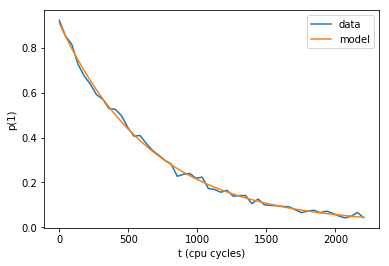

In [8]:
from scipy.optimize import curve_fit

# scale data to cycles from blocks of 45
x = np.array(range(len(circuits))) * 45

# fully parameterized exponential decay model
def model(t, a, b, c):
    return a * np.exp(-b * t) + c

# fit curve with scipy
a, b, c = curve_fit(model, x, exp_p, p0=[0.5, 0., 0])[0]
fig, ax = plt.subplots()
ax.plot(x, exp_p, label='data')
ax.plot(x, model(x, a, b, c), label='model')
ax.set_xlabel('t (cpu cycles)')
ax.set_ylabel('p(1)')
ax.legend()
print(a, b, c)

The IBM Q Experience website gives an approximately 5 GHz frequency for the Melbourne device. With our data, this implies a relaxation time constant of approximately τ = 0.134 μs. This is, of course, an order of magnitude lower than the even the smallest calibration value on the IBM website, and two orders of magnitude lower than the typical value. I'm not sure where my calculations are wrong (I suspect that we shouldn't be directly using the 5 GHz frequency value).